# Fundamentos de Computação Gráfica
# Trabalho 2 - Escala Mel

O primeiro passo é importar os pacotes do python necessários para o desenvolvimento do trabalho. 
Aqui usarei o numpy, o matplotlib e o scipy.

In [1]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.fftpack import dct

Neste ponto, irei importar o arquivo contendo o sinal ao qual o algoritmo para desenvolver a escala MEL será aplicado.

In [2]:
(freq, sinal) = scipy.io.wavfile.read('english.wav')

Agora vamos visualizar o sinal em uma forma gráfica. Para tanto, criemos uma função para plotar o sinal .wav, assim podemos reutilizar a função sempre que necessário.

In [3]:
def plot_wav(sample_rate, signal, title=None):
    
    time = np.arange(len(signal))/float(sample_rate)
    
    plt.figure(figsize=(30, 4))
    plt.title(title)
    plt.fill_between(time, signal, color='b') 
    plt.xlim(time[0], time[-1])
    plt.xlabel('tempo (s)')
    plt.ylabel('amplitude')
    plt.grid(True)
    plt.show()

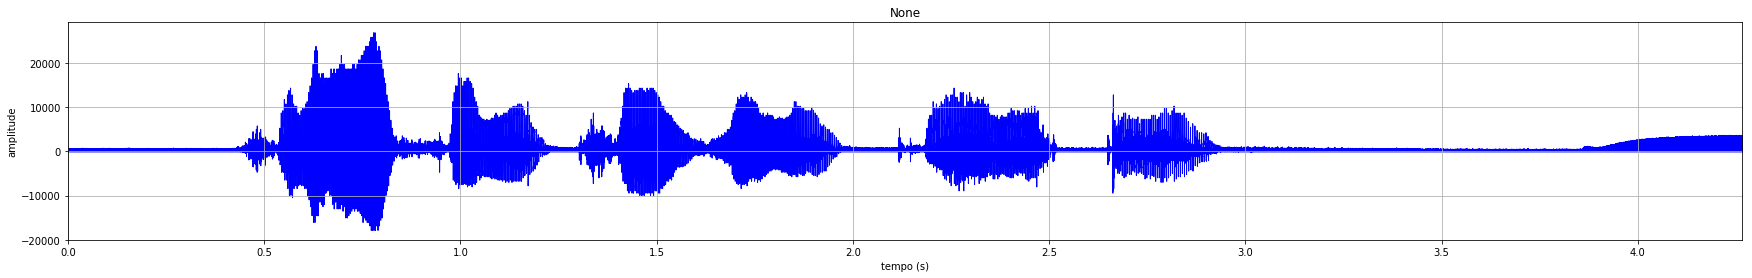

In [4]:
#visualizando o sinal lido do arquivo 'english.wav'
plot_wav(freq, sinal)

O primeiro passo do algoritmo é aplicar uma pré ênfase ao sinal. tal pré ênfase é dada pela fórmula $$y \left( t \right) = x \left( t \right) - \alpha x\left( t - 1 \right)$$ onde $t$ é o tempo, $x \left( t \right)$ é o valor da frequência no ponto $t$, $\alpha$ é o coeficiente da pré ênfase e $y \left( t \right)$ é o sinal enfatizado.
Os coeficientes $\alpha$ normalmente utilizados são 0.95 e 0.97. Vamos utilizar ambos e comparar os resultados.

In [5]:
def pre_enfase1(sinal):
    pre_enf = 0.95
    sinal_enfatizado = np.append(sinal[0], sinal[1:] - pre_enf * sinal[:-1])
    return sinal_enfatizado

def pre_enfase2(sinal):
    pre_enf = 0.97
    sinal_enfatizado = np.append(sinal[0], sinal[1:] - pre_enf * sinal[:-1])
    return sinal_enfatizado

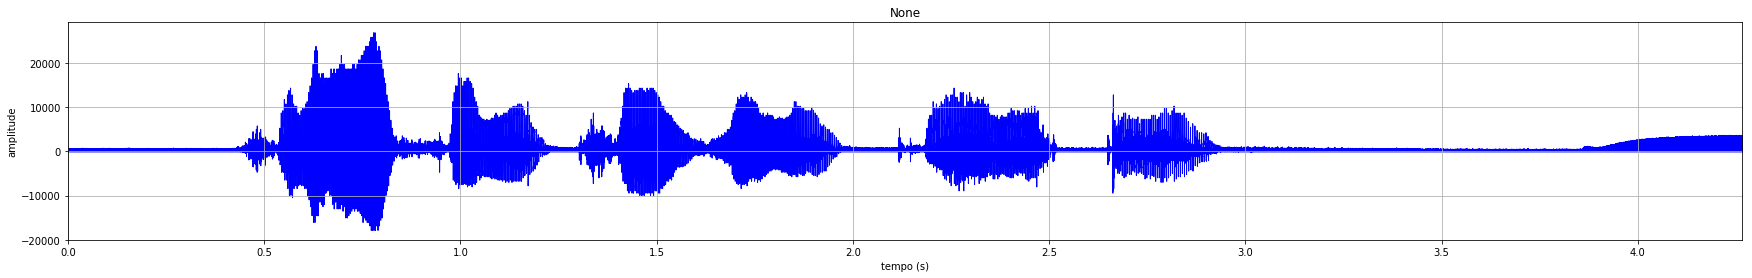

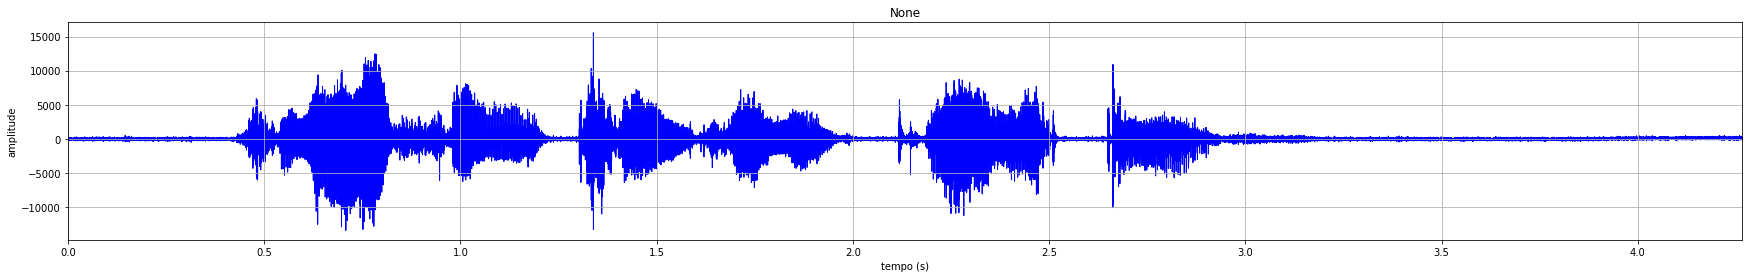

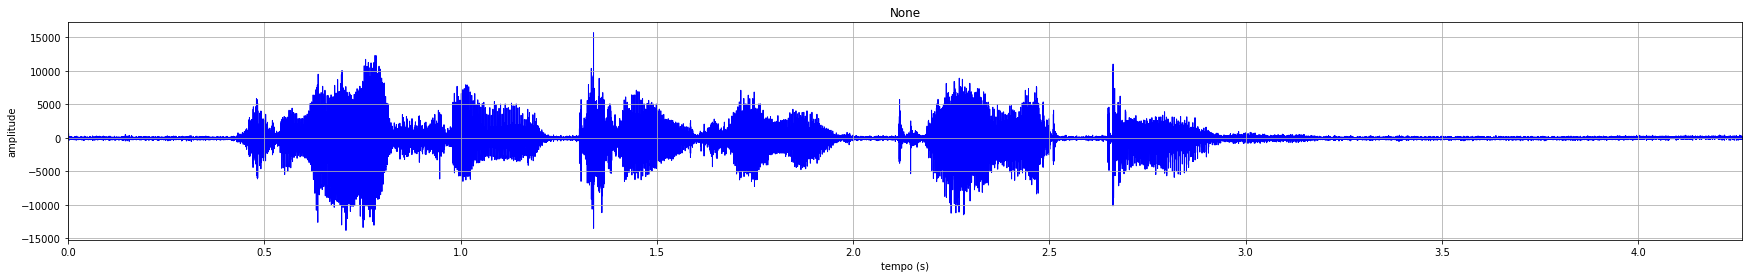

In [6]:
sinal_enfatizado1 = pre_enfase1(sinal)
sinal_enfatizado2 = pre_enfase2(sinal)

plot_wav(freq, sinal)
plot_wav(freq, sinal_enfatizado1)
plot_wav(freq, sinal_enfatizado2)

Dentre os gráficos acima, o primeiro é o sinal original e os outros dois representam o sinal após a pré ênfase com 0.95 e 0.97 respectivamente. Não há diferença perceptível entre eles, entretanto é visível a diferença entre o sinal original e a pré ênfase. Os pontos de maior amplitude são destacados.

O próximo passo do algoritmo consiste em dividir o sinal em frames de 20 a 40ms. Utiliza-se por padrão 25ms. Também é necessário definir um "passo" para esses frames. Que representa o tempo entre o início de um frame e o início do frame seguinte. Por padrão utiliza-se 10ms para o passo.

In [7]:
#separando o sinal em frames

#tamanho do frame em milissegundos
tam_frame_ms = 0.025 #25ms

#"passo" do frame em milissegundos
frame_pas_ms = 0.01 #10ms

#como cada segundo possui 8000 dados no array, precisamos calcular o tamanho do frame levando este dado em consideração
tam_sinal = len(sinal) #calculando o tamanho do sinal
tam_frame = int(tam_frame_ms * freq)
frame_pas = int(frame_pas_ms * freq)

#aqui vamos calcular o número de frames que o sinal vai conter
#a maneira mais fácil é determinar o número de "passos" que o primeiro frame vai efetuar até percorrer todo o sinal.
#Entretanto, o tamanho do frame é maior do que o passo, então primeiro é necessário subtratir do tamanho do sinal o valor do
#tamanho do frame. Depois disso é necessário dividir o resultado pelo tamanho do "passo" do frame. Isso nos dará um valor
#para o número de frames. Por fim, como é possível que o resultado do último cálculo não seja inteiro, então utilizaremos
#o comando .ceil do numpy para retornar o primeiro valor inteiro maior do que o resultado.
num_frames = int(np.ceil((tam_sinal - tam_frame)/frame_pas))

#depois do cálculo acima, o sinal que obtido não será mais o sinal original, mas sim um sinal ligeiramente maior. Isso se dá
#por ter sido utilizado o comando .ceil. Então agora para calcular o sinal atual basta executar o procedimento abaixo.
tam_sinal_atual = num_frames * frame_pas + tam_frame

#O valor acima é um valor inteiro, precisa-se de um array com tamanho igual ao valor de tam_sinal_atual
m_zeros = np.zeros((tam_sinal_atual - tam_sinal))
sinalN = np.append(sinal, m_zeros)
sinalN = sinalN.astype(int)
#agora temos um array correspondendo ao sinal que tem o tamanho necessário
#o procedimento acima poderia ser realizado de outras maneiras (uma delas está descrita abaixo), entretanto achei mais
#simples um leitor entender
#
#uma outra forma de obter a array supracitada
#sinal = np.zeros((tam_sinal_atual))
#for i in range(tam_sinal):
#    np.put(sinal, [i], audio[1][i])
#sinal.astype(int)

#Agora para terminar a separação em frames do sinal, gerando array de arrays onde cada elemento é um frame
indices = np.tile(np.arange(0, tam_frame), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_pas, frame_pas), (tam_frame, 1)).T
frames = sinalN[indices]

Depois de separar o sinal em frames, o algoritmo calcula o periodogram estimate do power spectrum. Para tanto é utilizado uma função hamming window. A função Hamming Window é dada pela fórmula $$\omega \left[ n \right] = 0,54 - 0,46\cos\left( \dfrac{2 \pi n}{N - 1} \right)$$ onde $n$ é um valor tal que $0 \leq n \leq N-1$ e $N$ é o tamanho da janela. No caso o tamanho da nossa janela é 25.
Vamos primeiro criar nossa função hamming window.

In [8]:
def hamming_W(array, tam_frame):
    valor_ham = []
    for i in range(tam_frame):
        valor_ham.append(0.54 -0.46*np.cos((2*scipy.pi*i)/(tam_frame - 1)))
    valor_ham = np.array(valor_ham)
    array = array*valor_ham
    return array

O gráfico da nossa função Hamming Window tem a seguinte forma:

In [9]:
def plot_window(frame_length):
    
    n = np.arange(frame_length)
    h = 0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length-1))
    plt.figure(figsize=(6, 5))
    plt.plot(h, label='Hamming')
    plt.ylabel('Amplitude', fontsize=16)
    plt.xlabel('Samples', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.savefig('hamming_window.jpg', bbox_inches='tight', dpi=200)
    plt.show()

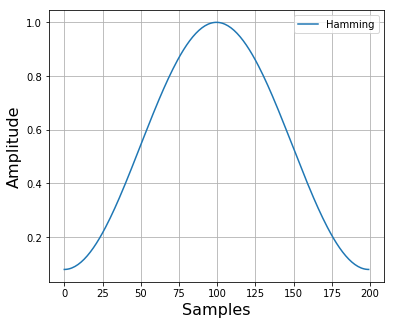

In [10]:
plot_window(tam_frame)

Agora com nossa função Hamming Window, vamos calcular o periodogram estimate do power spectrum. Para isso vamos aplicar uma Transformada de Fourier na frequência obtida em cada janela utilizando um número N de pontos nesta transformada (NFFT N-point Frequency Fourier Transformation). Aqui vamos utilizar a função do numpy que calcula a nfft e vamos utilizar a seguinte função para calcular o Power Spectrum: $$P = \dfrac{|FFT\left( x_i \right)|^2}{N}$$ onde $x_i$ é a i-ésima janela e N é o número de pontos.

In [11]:
#Aplicando a função Hamming Window
frames = hamming_W(frames, tam_frame)

#aplicando a transformada de Fourier
NFFT = 512
frames_transf = np.absolute(np.fft.rfft(frames, NFFT))
Pow_Spec_frames = ((frames_transf)**2)/NFFT

Agora temos o power spectrum. Com isso podemos passar ao próximo passo do algorítmo, que consiste em aplicar os mel filter banks nos power spectrum. O algoritmo informa que o número de filtros a serem utilizados varia de 20 até 40 filtros. Vamos efetuar o algoritmo para 20, 30 e 40 filtros para verificar se há alguma diferença significativa que justifique a utilização de um maior ou menor número de filtros.
Neste passo, primeiro se estabelece o número de filtros, o qual primeiro utilizaremos 40, uma frequência baixa e uma frequência alta.

In [12]:
nfil = 40
freq_mel_baixa = 0
freq_mel_alta = (2595 * np.log10(1 + (freq / 2) / 700))

O próximo passo é criar, na escala mel, pontos igualmente espaçados entre a frequência alta e a frequência baixa. O número de pontos entre tais frequências deve ser igual ao número de filtros, ou seja, ao final do processo teremos um número de pontos igual ao número de filtros acrescidos de dois pontos (os extremos).

In [13]:
pontos_freq_mel = np.linspace(freq_mel_baixa, freq_mel_alta, nfil + 2)

Após criar estes pontos, devemos transformar estes pontos da escala Mel para a frequência em Hz. Para transformar escala Hz em escala Mel utilizamos $$Mel\left(Hz\right) = 2595\log_{10}\left( 1 + \dfrac{Hz}{700} \right)$$ onde Hz é a frequência em Hz e Mel(Hz) é a frequência em Mel equivalente. Para transformar Mel em Hz basta aplicar a função inversa: $$Hz\left( Mel \right) = 700\left( 10^{\frac{Mel}{2595}} -1 \right)$$ que obteremos o valor desejado.

In [14]:
pontos_hertz = (700 * (10 ** (pontos_freq_mel / 2595) - 1))

Segundo o algoritmo, não temos a resolução da frequência requerida para colocar os filtros nos pontos exatos que calculamos acima, portanto é necessário arredondar os valores deles. Para arredondar os valores vamos utilizar a seguinte função $f\left( i \right) = floor\left(\left( nfft + 1 \right) * h\left( i \right) \mbox{ } / \mbox{ } frequência \right)$, onde $f(i)$ é a frequência arredondada, $h(i)$ é a frequência em Hz, nfft é o nfft utilizado na transformada de fourier e frequência é a frequência do sinal, no caso a frequência é 8000Hz.

In [15]:
bin = np.floor((NFFT + 1) * pontos_hertz / freq)

Depois de ter arredondado os valores, vamos criar os filter banks. O algoritmo nos informa que a fórmula utilizada para criar os filter banks é dada por $$H_m \left( k \right) = 
\left\{
        \begin{array}{11}
        0 & \mbox{, se } k < f\left( m - 1 \right) \\
        \dfrac{k-f\left(m-1\right)}{f\left(m\right)-f\left(m-1\right)} & \mbox{, se } f\left(m-1\right) \leq k \leq f\left(m\right)\\
        \dfrac{f\left(m+1\right)-k}{f\left(m+1\right)-f\left(m\right)} & \mbox{, se } f\left(m\right) \leq k \leq f\left(m+1\right)\\
        0 & \mbox{, se } f\left(m+1\right)<k
        \end{array}
\right.$$ onde $k$ é um valor dentro da janela, $H_m\left(k\right)$ é o valor de K no m-ésimo filtro e $f\left(m\right)$ é a m-ésima frequência arredondada.

Como para cada filtro boa parte dos valores são constituídos de zero, então vamos tomar uma abordagem mais prática, vamos criar uma lista auxiliar que terá todos os valores iguais a zero e vamos alterar apenas os valores desejados e "jogar" este valor dentro de uma lista que será constituída dos nossos filter banks.

In [16]:
fbank = np.zeros((nfil, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfil + 1):
    f_m_minus = int(bin[m - 1])
    f_m = int(bin[m])
    f_m_plus = int(bin[m + 1])
    
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

Agora que temos nossos filter banks, podemos visualizá-los, para isto basta criarmos uma função para criar o gráfico.

In [17]:
def plot_fbank(fbank, sample_rate, low_freq):
    
    plt.figure(figsize=(11, 2.5))
    plt.title('Filter bank on a Mel-Scale')
    plt.plot(np.linspace(low_freq, (sample_rate / 2), 257), fbank.T)
    plt.ylabel('Amplitude', fontsize=16)
    plt.xlabel('Frequency', fontsize=16)
    plt.grid(True)
    plt.savefig('mel_filters.jpg', bbox_inches='tight', dpi=200)
    plt.show()

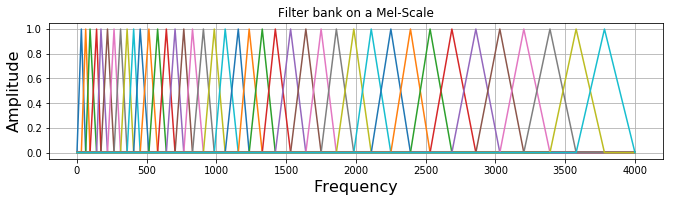

In [18]:
plot_fbank(fbank, freq, freq_mel_baixa)

O algoritmo nos diz para, a partir dos filter banks, proceder da seguinte maneira:

1º) Pegar o logaritmo da energia de cada filter bank.

2º) Pegar a DCT (Discrete Cosine Transform) do log da energia de cada filter bank.

3º) Manter os coeficientes DCT 2 a 13 e descartar o resto.

Primeiro, vamos pegar os logs.

In [19]:
filter_banks = np.dot(Pow_Spec_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)

Agora vamos aplicar o DCT, para isso vamos utilizar a função dct do numpy. É necessário aqui decidir o número de coeficientes que iremos guardar. Como o algoritmo dos informa, vamos utilizar o número de coeficientes igual a 12.

In [20]:
ceps_num = 12
Mel_freq_cc = dct(filter_banks, norm='ortho')[:, 1 : (ceps_num + 1)]

Por fim, vamos verificar como ficou o espectrograma e o mfcc (Mel Frequency Cepstral Coefficients). Vamos criar duas funções, cada uma vai criar um gráfico para o respectivo objeto que queremos visualizar.

In [21]:
def plot_spectrogram(filter_banks):
    
    plt.imshow(np.flipud(filter_banks.T), cmap=cm.jet, aspect=0.32, extent=[0,4,0,4])
    plt.title('Spectrogram of the Signal')
    plt.ylabel('Frequency (kHz)', fontsize=16)
    plt.xlabel('Time (s)', fontsize=16)
    plt.savefig('filter_banks_raw.jpg', bbox_inches='tight', dpi=200)
    plt.show()

In [22]:
def plot_mfcc(num_ceps, mfcc):
    
    plt.imshow(np.flipud(mfcc.T), cmap=cm.jet, aspect=0.08, extent=[0,4,1,num_ceps])
    plt.title('MFCCs')
    plt.ylabel('MFCC Coefficients', fontsize=16)
    plt.xlabel('Time (s)', fontsize=16)
    plt.savefig('mfcc_raw.jpg', bbox_inches='tight', dpi=200)
    plt.show

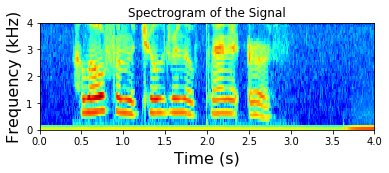

In [23]:
plot_spectrogram(filter_banks)

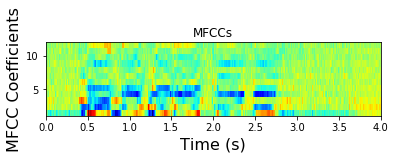

In [24]:
plot_mfcc(ceps_num, Mel_freq_cc)

Agora que já vimos como ficam o gráfico dos filter banks, o espectrograma e o MFCC, vamos fazer o mesmo processo para 20 e 30 filter banks e comparar os resultados.

In [25]:
nfil20 = 20
freq_mel_baixa20 = 0
freq_mel_alta20 = (2595 * np.log10(1 + (freq / 2) / 700))
pontos_freq_mel20 = np.linspace(freq_mel_baixa20, freq_mel_alta20, nfil20 + 2)
pontos_hertz20 = (700 * (10 ** (pontos_freq_mel20 / 2595) - 1))
bin20 = np.floor((NFFT + 1) * pontos_hertz20 / freq)
fbank20 = np.zeros((nfil20, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfil20 + 1):
    f_m_minus20 = int(bin20[m - 1])
    f_m20 = int(bin20[m])
    f_m_plus20 = int(bin20[m + 1])
    
    for k in range(f_m_minus20, f_m20):
        fbank20[m - 1, k] = (k - bin20[m - 1]) / (bin20[m] - bin20[m - 1])
    for k in range(f_m20, f_m_plus20):
        fbank20[m - 1, k] = (bin20[m + 1] - k) / (bin20[m + 1] - bin20[m])
filter_banks20 = np.dot(Pow_Spec_frames, fbank20.T)
filter_banks20 = np.where(filter_banks20 == 0, np.finfo(float).eps, filter_banks20)
filter_banks20 = 20 * np.log10(filter_banks20)
ceps_num20 = 12
Mel_freq_cc20 = dct(filter_banks20, norm='ortho')[:, 1 : (ceps_num + 1)]

In [26]:
nfil30 = 30
freq_mel_baixa30 = 0
freq_mel_alta30 = (2595 * np.log10(1 + (freq / 2) / 700))
pontos_freq_mel30 = np.linspace(freq_mel_baixa30, freq_mel_alta30, nfil30 + 2)
pontos_hertz30 = (700 * (10 ** (pontos_freq_mel30 / 2595) - 1))
bin30 = np.floor((NFFT + 1) * pontos_hertz30 / freq)
fbank30 = np.zeros((nfil30, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfil30 + 1):
    f_m_minus30 = int(bin30[m - 1])
    f_m30 = int(bin30[m])
    f_m_plus30 = int(bin30[m + 1])
    
    for k in range(f_m_minus30, f_m30):
        fbank30[m - 1, k] = (k - bin30[m - 1]) / (bin30[m] - bin30[m - 1])
    for k in range(f_m30, f_m_plus30):
        fbank30[m - 1, k] = (bin30[m + 1] - k) / (bin30[m + 1] - bin30[m])
filter_banks30 = np.dot(Pow_Spec_frames, fbank30.T)
filter_banks30 = np.where(filter_banks30 == 0, np.finfo(float).eps, filter_banks30)
filter_banks30 = 20 * np.log10(filter_banks30)
ceps_num20 = 12
Mel_freq_cc30 = dct(filter_banks30, norm='ortho')[:, 1 : (ceps_num + 1)]

Vamos comparar os filter banks.

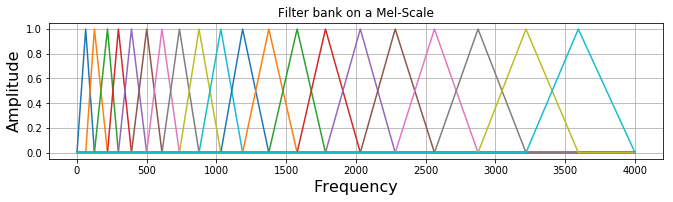

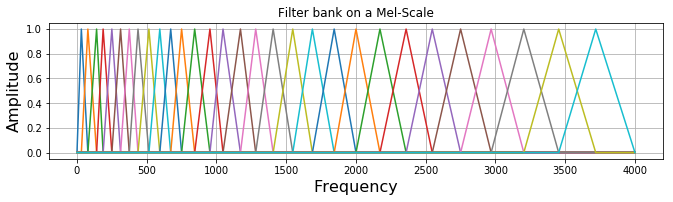

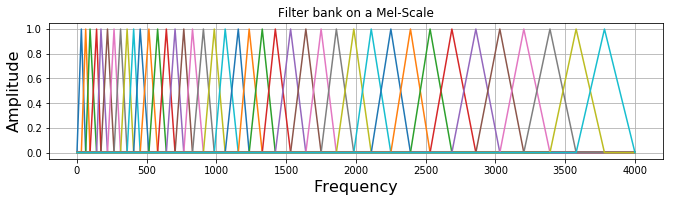

In [27]:
plot_fbank(fbank20, freq, freq_mel_baixa)
plot_fbank(fbank30, freq, freq_mel_baixa)
plot_fbank(fbank, freq, freq_mel_baixa)

Podemos perceber um estreitamento dos gráficos. Entretanto vamos avaliar os outros dois gráficos, a saber o espectrograma e o mfcc, para avaliar de que maneira esse comportamento pode influenciar o algoritmo.

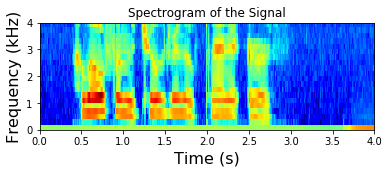

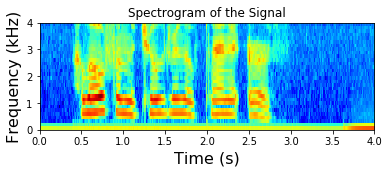

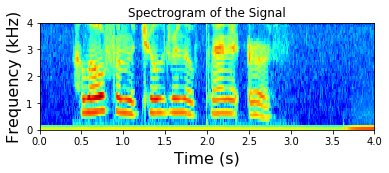

In [28]:
plot_spectrogram(filter_banks20)
plot_spectrogram(filter_banks30)
plot_spectrogram(filter_banks)

Observando o espectrograma podemos supor que o número de filtros interfere na qualidade do processamento que fazemos com o sinal, de maneira que, quanto mais filtros, mais claro o resultado do processamento.

Agora vamos avaliar o MFCC para verificar se há alguma diferença significativa.

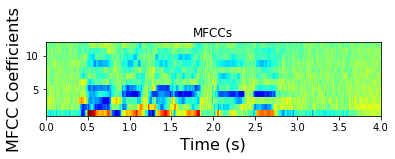

In [29]:
plot_mfcc(ceps_num, Mel_freq_cc20)

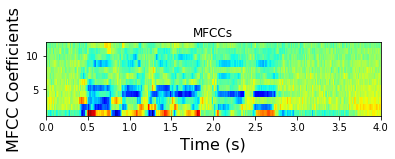

In [30]:
plot_mfcc(ceps_num, Mel_freq_cc30)

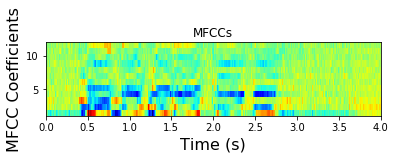

In [31]:
plot_mfcc(ceps_num, Mel_freq_cc)

Não há diferença perceptível entre os gráficos.